In [21]:
import trimesh
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
class Camera():
    # camera coordinates: y up, z forward, x right.
    # consistent with blender definitions.
    # res = [w,h]
    def __init__(self):
        self.position = np.array([1.6, 0, 0])
        self.rx = np.array([0, 1, 0])
        self.ry = np.array([0, 0, 1])
        self.rz = np.array([1, 0, 0])
        self.focal_length = 0.05
        self.res = [600,600]
        # set the diagnal to be 35mm film's diagnal
        self.set_diagal((0.036**2 + 0.024**2)**0.5)

    def rotate(self, rot_mat):
        self.rx = rot_mat[:, 0]
        self.ry = rot_mat[:, 1]
        self.rz = rot_mat[:, 2]

    def move_cam(self, new_pos):
        self.position = new_pos

    def set_pose(self, inward, up):
        # print(inward)
        # print(up)
        self.rx = np.cross(up, inward)
        self.ry = np.array(up)
        self.rz = np.array(inward)
        self.rx = self.rx / np.linalg.norm(self.rx)
        self.ry = self.ry/np.linalg.norm(self.ry)
        self.rz = self.rz/np.linalg.norm(self.rz)

    def set_diagal(self, diag):
        h_relative = self.res[1] / self.res[0]
        self.sensor_width = np.sqrt(diag**2 / (1 + h_relative**2))

    def lookat(self, orig, target, up):
        self.position = np.array(orig)
        target = np.array(target)
        inward = self.position - target
        right = np.cross(up, inward)
        up = np.cross(inward, right)
        self.set_pose(inward, up)
        
    def generate_rays(self):
        orig = np.zeros([self.res[0],self.res[1],3])
        orig[:,:,0] = self.position[0]
        orig[:,:,1] = self.position[1]
        orig[:,:,2] = self.position[2]
        w = self.sensor_width
        h_linspace = np.linspace(-w / 2, w / 2, self.res[0])                        
        w_linspace = np.linspace(-w / 2, w / 2, self.res[1])
        H,W = np.meshgrid(h_linspace,w_linspace)
        H = H[...,None]
        W = W[..., None]
        ends = (self.position-self.rz*self.focal_length)+H*self.ry[None,None,:] + W*self.rx[None,None,:]
        direction = (ends-orig)/np.linalg.norm(ends-orig,axis=2,keepdims=True)
        return orig,direction,ends

cube_path = '/data/vision/billf/scratch/ztzhang/data/non-rigid/3d_models/cube_simple.obj'
mesh = trimesh.load(cube_path)

In [22]:
# use faces as elements:
point_positions = mesh.triangles_center
point_adjacencies = mesh.face_adjacency

In [23]:
print(point_adjacencies.shape)
print(point_positions.shape)

(798, 2)
(588, 3)


In [24]:
camera = Camera()
camera.lookat(np.array([-2,-2,-2]),np.array([0,0,0]),np.array([0,0,1]))
o,d,end = camera.generate_rays() # generates vectors and a bunch of rays
inc=trimesh.ray.ray_pyembree.RayMeshIntersector(mesh)
o = o.reshape(-1,3)
d = d.reshape(-1,3)
fid = inc.intersects_first(o,d) # list of indices of hit triangles
fid = fid.reshape([600,600])
# show meshes
# f, axarr = plt.subplots(2,2)
# axarr[0,0] = plt.imshow(image_datas[0])
# axarr[0,1] = plt.imshow(image_datas[1])
# axarr[1,0] = plt.imshow(image_datas[2])
# axarr[1,1] = plt.imshow(image_datas[3])
# plt.imshow(fid, interpolation='none')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


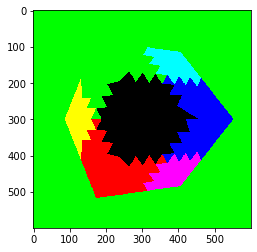

In [25]:
#positions
newarray = np.round(point_positions[fid]*255)
# print(newarray)
plt.imshow(newarray, interpolation='none')

# (point_positions[1,:]+1)/2

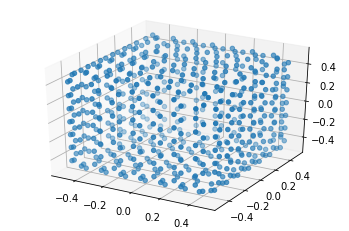

In [26]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xyz = point_positions
ax.scatter3D(xyz[:,0], xyz[:,1], xyz[:,2], cmap='viridis')

In [32]:

def genId(cam_pos):
    """
    @input: tuple of x y z of camera
    @output list of visible indexes
    """
    camera = Camera()
    camera.lookat(np.array(cam_pos),np.array([0,0,0]),np.array([0,0,1]))
    o,d,end = camera.generate_rays() # generates vectors and a bunch of rays
    inc=trimesh.ray.ray_pyembree.RayMeshIntersector(mesh)
    o = o.reshape(-1,3)
    d = d.reshape(-1,3)
    fid = inc.intersects_first(o,d) # list of indices of hit triangles
    # fid = fid.reshape([600,600])
    alist = np.array(fid)
    return alist



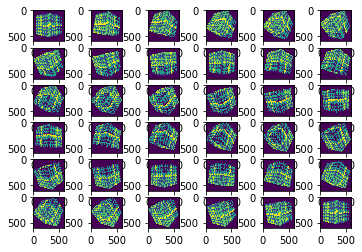

In [85]:
t = np.linspace(0,np.pi*2,36)
sine=np.sin(t)
cosine=np.cos(t)
data = []
animlist = []
for s,c in zip(sine,cosine):
    data.append(genId([2*c,2*s,2]).reshape([600,600]))

# fid = genId([2,2*0,2]).reshape([600,600])
# fid2 = genId([2*0.98480775301,2*0.17364817766,2]).reshape([600,600])
# fid3 = genId([2*0.93969262078,2*0.34202014332,2]).reshape([600,600])
# fid4 = genId([2*0.86602540378,1,2]).reshape([600,600])

# show meshes
f, axarr = plt.subplots(6,6)
for i in range(6):
    for j in range(6):
        
        im = axarr[i,j].imshow(data[i*6+j],animated= True)
        animlist.append([im])

# plt.imshow(f, interpolation='none')

In [88]:
#make animation
import matplotlib.animation as animation
# plt.cla()
fig = plt.figure()
# print(animlist[0][0].shape)
ani = animation.ArtistAnimation(fig, animlist, interval=100, blit=False,
                                repeat_delay=1000)
print(ani[0])
ani.save('dynamic_images.mp4')

plt.show()

TypeError: 'ArtistAnimation' object is not subscriptable